In [1]:
from datetime import datetime
from numpy import log, sqrt, exp, dot
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.optimize as spo, scipy.interpolate as spi, scipy.stats as sps
import seaborn as sns
sns.set()
import os
os.chdir(r'C:\Users\54638\Desktop\Python\vol') # set path
import pandas_datareader as pdr

In [80]:
tickers = ['0700.HK', 'AAPL', 'GLD', '600519.SS', 'MSFT', 'MCD', 'VBMFX'] # 
# if yahoo doesn't contain the exact start day, will return one row only 
tmp = {ticker: pdr.get_data_yahoo(ticker, start = datetime(2010,1,4)) for ticker in tickers}
price = pd.DataFrame({ticker: tmp[ticker]['Adj Close'] for ticker in tickers})

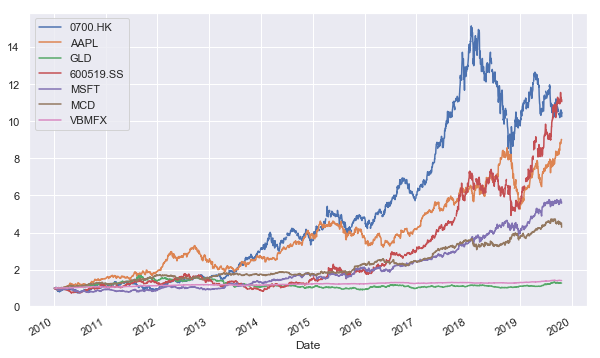

In [81]:
(price/price.iloc[0]).plot(figsize = (10,6))

In [82]:
# check NaN happens in which day
# price[price.isna().any(axis = 1)]

price.dropna(inplace = True)
wp = price[price.index.dayofweek == 4] # weekly price
wr = log((wp/wp.shift()).dropna()) # weekly return
wmean = wr.mean() * 52 #
wcov = wr.cov() * 52 # covariance matrix
wmean

0700.HK      0.269893
AAPL         0.250415
GLD          0.026522
600519.SS    0.281638
MSFT         0.198402
MCD          0.173227
VBMFX        0.039244
dtype: float64

In [83]:
wcov

,0700.HK,AAPL,GLD,600519.SS,MSFT,MCD,VBMFX
0700.HK,0.103559,0.024127,0.005637,0.019367,0.019362,0.004627,-0.000328
AAPL,0.024127,0.079548,0.004050,0.011398,0.027466,0.012040,-0.001409
GLD,0.005637,0.004050,0.024211,0.002292,-0.000839,-0.000055,0.001571
600519.SS,0.019367,0.011398,0.002292,0.102080,0.011071,0.001625,-0.000013
MSFT,0.019362,0.027466,-0.000839,0.011071,0.053340,0.014838,-0.001444
MCD,0.004627,0.012040,-0.000055,0.001625,0.014838,0.024043,-0.000237
VBMFX,-0.000328,-0.001409,0.001571,-0.000013,-0.001444,-0.000237,0.001228


In [84]:
def prot_ret(weights):
    return sum(weights * wmean)
def prot_vol(weights):
    return sqrt(dot(weights,dot(wcov, weights.T)))

pnum = 3000 # portfolio number
anum = len(tickers) # asset number
pret = np.zeros(pnum) # portfolio return
pvol = np.zeros(pnum) # portfolio volatility
for i in range(pnum):
    weights = np.random.rand(anum)
    weights /= np.sum(weights) # 
    pret[i] = prot_ret(weights)
    pvol[i] = prot_vol(weights)
    

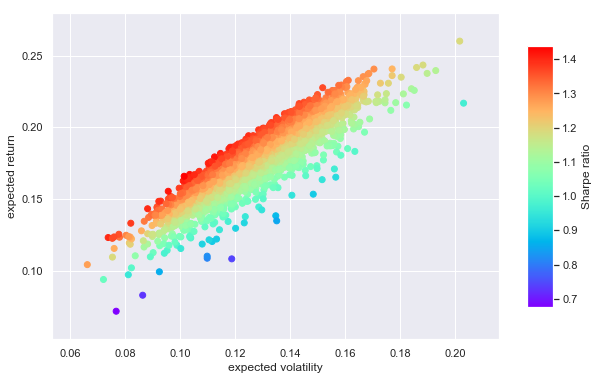

In [85]:
rf = 0.02
plt.figure(figsize = (10,6))
plt.scatter(pvol, pret, c = (pret-rf)/pvol, marker ='o', cmap = 'rainbow')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(shrink = 0.8, aspect = 10,label = 'Sharpe ratio')

# efficient frontier

In [86]:
enum = 100
eret = np.linspace(min(wmean),max(wmean), enum)
evol = np.zeros_like(eret)
eweights = [1. / anum] * anum
bnds = [(0,1) for _ in range(anum)]
for i in range(enum):
    cons = ({'type':'eq','fun':lambda x: 1 - sum(x)}, {'type':'eq','fun':lambda x: eret[i] - prot_ret(x)})
    res = spo.minimize(prot_vol, eweights, method = 'SLSQP', bounds = bnds, constraints = cons )
    evol[i] = res['fun']

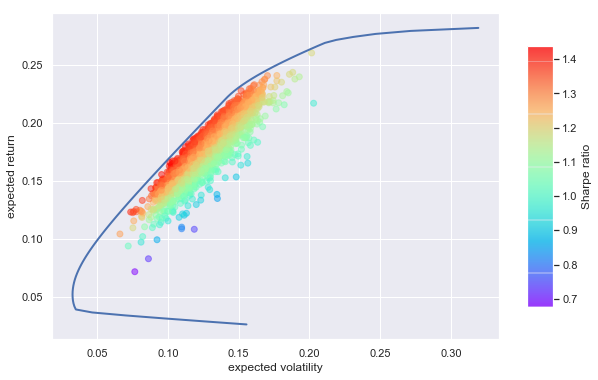

In [87]:
plt.figure(figsize = (10,6))
plt.scatter(pvol, pret, c = (pret-rf)/pvol, marker ='o', cmap = 'rainbow', alpha = 0.5)
plt.plot(evol, eret, 'b-', lw = 2)

plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(shrink = 0.8, aspect = 10,label = 'Sharpe ratio')

In [88]:
# Global minimum variance protfolio
bnds = [(0,1) for _ in range(anum)]
cons = ({'type':'eq','fun':lambda x: 1 - sum(x)})
gmvp = spo.minimize(prot_vol, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)
print(gmvp['fun'], gmvp['x'])

0.032624022993229154 [2.62146823e-03 1.43466197e-02 9.51387406e-18 4.97637949e-03
 2.78175190e-02 2.82523726e-02 9.21985641e-01]


In [106]:
# tangent portfolio
def sharpe_ratio(weights): # target function
    return -(prot_ret(weights)-rf) / prot_vol(weights)

bnds = [(0,1) for _ in range(anum)]
cons = ({'type':'eq','fun':lambda x: 1 - sum(x)})
tangent = spo.minimize(sharpe_ratio, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)
print(-tangent['fun'], tangent['x'].round(4))

1.577001848851309 [0.0456 0.0501 0.     0.065  0.0271 0.1619 0.6503]


In [90]:
# constraints on position, maximum concentration
cnum = 100
max_concentration = 0.3
cret = np.linspace(min(wmean),max(wmean), cnum)
cvol = np.zeros_like(cret)
eweights = [1. / anum] * anum
bnds = [(0,max_concentration) for _ in range(anum)]
for i in range(cnum):
    cons = ({'type':'eq','fun':lambda x: 1 - sum(x)}, {'type':'eq','fun':lambda x: cret[i] - prot_ret(x)})
    res = spo.minimize(prot_vol, eweights, method = 'SLSQP', bounds = bnds, constraints = cons )
    cvol[i] = res['fun']

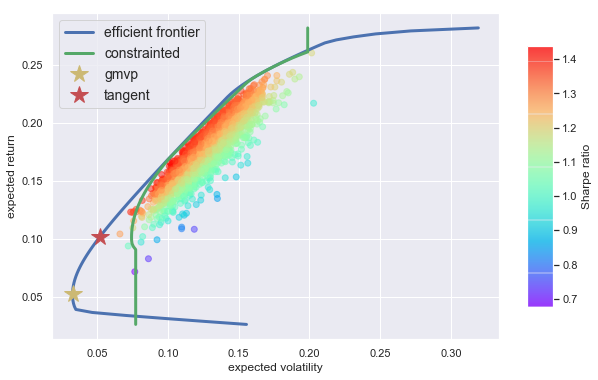

In [108]:
plt.figure(figsize = (10,6))

plt.scatter(pvol, pret, c = (pret-rf)/pvol, marker ='o', cmap = 'rainbow', alpha = 0.5)

plt.plot(evol, eret, 'b-', lw = 3, label='efficient frontier')
plt.plot(cvol, cret, 'g-', lw = 3, label='constrainted')

plt.plot(prot_vol(gmvp['x']), prot_ret(gmvp['x']), 'y*', markersize = 18, label = 'gmvp')
plt.plot(prot_vol(tangent['x']), prot_ret(tangent['x']), 'r*', markersize = 18, label = 'tangent')

plt.legend(fontsize = 14)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(shrink = 0.8, aspect = 10,label = 'Sharpe ratio')